# Data treatment and Neural Network Training using IPMA data
João Oliveira and Edgar Mendes

In [1]:
#-----------------------Imports

import os
import requests
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import io
from io import BytesIO
from PIL import Image, ImageDraw
import pytz

#-----------------------Constantes

DADOS_ULTIMAS_3_HORAS = "https://api.ipma.pt/open-data/observation/meteorology/stations/obs-surface.geojson" #por exemplo se forem 9PM tem os dados entre 5PM e 7PM de hora a hora para todas as estações
DADOS_IDS_ESTACOES = "https://api.ipma.pt/open-data/observation/meteorology/stations/stations.json"
local_tz = pytz.timezone('Europe/Lisbon') #Define o fuso horário local

#-----------------------Funções

def get_data(url):
    response = requests.get(f"{url}")
    if response.status_code == 200:
        print("Sucessfully fetched the data!") 
        return response.json() #https://www.educative.io/answers/how-to-make-api-calls-in-python
    else:
        print(f"Hello there, there's a {response.status_code} error with your request.")
        
def normalize_precipitation_value(precipitation_value):
    return int(round((precipitation_value/240)*100,0)) #o valor normalizado ta a ser arredondado pq as pastas sao de valores inteiros. https://www.ipma.pt/pt/oclima/extremos.clima/ Vou usar o valor máximo aqui como referencia

def get_images_and_data_from_ipma():
    data = get_data(DADOS_ULTIMAS_3_HORAS)
    # Faz a requisição à apiEstacoes e à apiMeteo para obter as informações meteorológicas 
    box = (570, 428, 770, 628) # esses valores foram escolhidos por testes. coordenadas da região de Viana do Castelo (x1, y1, x2, y2) (1500x2331)

    final_result = {}
    for feature in data['features']:
        station_data = feature['properties']
        id_estacao = station_data['idEstacao']
        # Converte a hora da estação para o fuso horário local
        date_time_utc = datetime.fromisoformat(station_data['time'])
        date_time = datetime.fromisoformat(station_data['time']).replace(tzinfo=pytz.utc).astimezone(local_tz)
        date_str, hour_str = date_time.strftime('%Y-%m-%d %H:%M').split()
        precipitation = station_data['precAcumulada']

        if date_str not in final_result:
            final_result[date_str] = {hour_str: precipitation}
        else:
            final_result[date_str][hour_str] = normalize_precipitation_value(max(0, precipitation))

        url_image = f"https://www.ipma.pt/resources.www/transf/radar/por/pcr-{date_time_utc.strftime('%Y-%m-%d')}T{date_time_utc.strftime('%H%M')}.png"
        response = requests.get(url_image)
        image_data = io.BytesIO(response.content)
        image = Image.open(image_data)
        print(f"{url_image} ({hour_str}h)")

        # Corte da imagem
        # verifica se a pasta id_estacao existe e cria se não existir
        if not os.path.exists(f"dataset/images/{id_estacao}"):
            os.makedirs(f"dataset/images/{id_estacao}")

        # verifica se a pasta date_str existe e cria se não existir
        if not os.path.exists(f"dataset/images/{id_estacao}/{date_str}"):
            os.makedirs(f"dataset/images/{id_estacao}/{date_str}")

        # Corta a imagem na região definida pelas coordenadas se for de viana do castelo
        if int(id_estacao) == 1240610:
            region = image.crop(box)
            region.save(f"dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
            region.close()
        else:
            # Salva a imagem cortada como um arquivo PNG
            image.save(f"dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
        image.close()
        # Verifica se o arquivo JSON para esta estação já existe, se não, cria o arquivo
        filename = f"dataset/precipitation/{id_estacao}.json"
        if not os.path.isfile(filename):
            with open(filename, 'w') as file:
                json.dump({}, file)

        # Carrega o conteúdo do arquivo JSON para a variável "precipitation_data"
        with open(filename, 'r') as file:
            precipitation_data = json.load(file)

        # Adiciona as informações meteorológicas ao arquivo JSON
        for date in final_result:
            if date not in precipitation_data:
                precipitation_data[date] = final_result[date]
            else:
                precipitation_data[date].update(final_result[date])

        # Escreve o conteúdo atualizado no arquivo JSON
        with open(filename, 'w') as file:
            json.dump(precipitation_data, file, indent=4)

    print("Dados atualizados com sucesso!")
    
def dict_to_array2D(input_dict):
    # Create an empty list to hold the values
    output_array = np.empty(0)
    # Loop over each key-value pair in the dictionary
    for date_dict in input_dict.values():
        for value in date_dict.values():
            # Append the value to the output array
            output_array = np.append(output_array,value)
    # Reshape to 2D array
    output_array = np.reshape(output_array, (-1, 1))
    # Return the output array
    return output_array


In [1]:
#--------Criação das pastas de 0 a 100

for i in range(101):
    os.mkdir(str(i)) #---Cria as pastas do 0 ao 100
print("Pastas criadas!")

Pastas criadas!


#  API Precipition Information
Observação Meteorológica de Estações, últimas 3 horas (formato GeoJSON) com as imagens (png)

(x1, y1, x2, y2) => (570, 428, 770, 628)


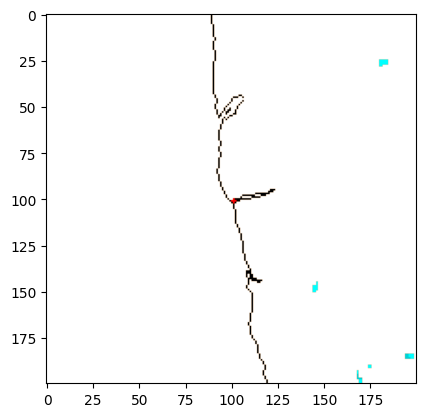

In [45]:
#--------Código auxiliar para o corte das regiões para a análise 

# Coordenadas da imagem (aproximação)
lat1, long1 = 43.95, -12.453377201650959
lat2, long2 = 34, -4.348615353313684

# Carrega a imagem
img = Image.open("dataset/teste.png")
dist = 200

# Coordenadas do ponto de corte (coordenadas da estação)
lat_corte, long_corte = 41.695, -8.82916 
    
#lat_corte, long_corte = 37.16925866835189, -7.40364787889199

# Calcula as coordenadas do canto superior esquerdo do corte ()
x = int(img.width * (long_corte - long1) / (long2 - long1) - (dist/2))
y = int(img.height * (lat_corte - lat1) / (lat2 - lat1) - (dist/2))
print(f'(x1, y1, x2, y2) => ({x}, {y}, {x + dist}, {y + dist})') # Mostra onde a imagem foi cortada (x1, y1, x2, y2)

# Desenha um ponto vermelho no centro da imagem
draw = ImageDraw.Draw(img)
draw.ellipse((x+(dist/2), y+(dist/2), x+((dist/2)+2), y+((dist/2)+2)), fill='red')

# Faz o corte de (dist x dist) pixels
corte = img.crop((x, y, x+dist, y+dist))

# Mostra a imagem cortada
plt.imshow(corte)
plt.show()

In [2]:
get_images_and_data_from_ipma()
#<class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDEBEF40>


Sucessfully fetched the data!
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (14:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1300.png (

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (15:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1400.png (

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (16:00h)
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-22T1500.png (

# Model Training


In [30]:
#-----------------------Imports

import numpy as np
import io

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras

from keras import layers
from keras import callbacks
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.utils.vis_utils import plot_model


#-----------------------Constantes

N_CHANNELS = 4
N_NEURONIOS = 32
FILTER_SIZE = 3
MAX_POOL_SIZE = (3,3)
N_CLASSES = 100
N_EPOCHS = 200
N_STRIDES = 2
DROPOUT_VALUE = 0.5
IMAGE_WIDTH, IMAGE_HEIGHT = 200,200

In [31]:
images_array = np.empty((0, IMAGE_WIDTH, IMAGE_HEIGHT, 4))
data_array = np.empty(0)
# Open the JSON file
with open('dataset/precipitation/1240610.json') as f:
    # Load the JSON data
    data = json.load(f)

data_array = dict_to_array2D(data)

#-----------------------------------------

images_folder_path = 'dataset/images/1240610/'

# Get a list of all the files in the current folder
file_list = os.listdir(images_folder_path)

# Filter the list to only include folders files
days_folders_list = [file for file in file_list if os.path.isdir(os.path.join(images_folder_path, file))]

for day_folder in days_folders_list:
    current_path = images_folder_path + day_folder
    #Get a list of all files in the folder 
    files_list = os.listdir(current_path)
    # Filter the list to only include images files
    image_list = [file for file in files_list if file.endswith('.png')]
    for i in range(len(image_list)):
        image_path = os.path.join(current_path, image_list[i])
        image = Image.open(image_path)
        img_np = np.array(image)
        images_array = np.append(images_array, [img_np], axis=0)
        
train_images, val_images, train_values, val_values = train_test_split(images_array, data_array, test_size=0.2, random_state=42)

train_images = tf.keras.utils.normalize(train_images, axis=1)
val_images = tf.keras.utils.normalize(val_images, axis=1)

In [32]:
#Ver quantos valores há

def flatten_array(input_array):
    output_array = np.reshape(input_array, (-1,))
    return output_array

def count_values(arr):
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    return counts

counts = count_values(flatten_array(data_array))
print(counts)

{0.0: 44, 1.0: 2, 5.0: 1}


In [33]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(N_NEURONIOS, MAX_POOL_SIZE, activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(N_NEURONIOS, FILTER_SIZE, strides=N_STRIDES, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=MAX_POOL_SIZE))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(N_NEURONIOS*2, FILTER_SIZE, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=MAX_POOL_SIZE))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(N_NEURONIOS*4, FILTER_SIZE, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=MAX_POOL_SIZE))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(N_NEURONIOS*8, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(DROPOUT_VALUE))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

#model.summary()

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [37]:
import pydot

print(pydot.__version__)

1.4.2


In [36]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
history = model.fit(train_images, train_values, epochs= N_EPOCHS, validation_data=(val_images, val_values))

Epoch 1/200
2/2 [==============================] - 2s 384ms/step - loss: 5.5975 - accuracy: 0.0000e+00 - val_loss: 4.5253 - val_accuracy: 0.0000e+00
Epoch 2/200
2/2 [==============================] - 1s 228ms/step - loss: 5.2942 - accuracy: 0.1351 - val_loss: 4.5479 - val_accuracy: 0.0000e+00
Epoch 3/200
2/2 [==============================] - 1s 226ms/step - loss: 4.9185 - accuracy: 0.1622 - val_loss: 4.6045 - val_accuracy: 0.0000e+00
Epoch 4/200
2/2 [==============================] - 1s 250ms/step - loss: 5.0404 - accuracy: 0.3243 - val_loss: 4.5441 - val_accuracy: 0.0000e+00
Epoch 5/200
2/2 [==============================] - 1s 228ms/step - loss: 4.6122 - accuracy: 0.3514 - val_loss: 4.4923 - val_accuracy: 0.0000e+00
Epoch 6/200
2/2 [==============================] - 1s 229ms/step - loss: 4.5011 - accuracy: 0.2432 - val_loss: 4.5430 - val_accuracy: 0.0000e+00
Epoch 7/200
2/2 [==============================] - 1s 226ms/step - loss: 4.6214 - accuracy: 0.2703 - val_loss: 4.4837 - val_ac

Epoch 58/200
2/2 [==============================] - 1s 296ms/step - loss: 0.8139 - accuracy: 0.8919 - val_loss: 1.1577 - val_accuracy: 0.9000
Epoch 59/200
2/2 [==============================] - 1s 240ms/step - loss: 1.0321 - accuracy: 0.8919 - val_loss: 1.0984 - val_accuracy: 0.9000
Epoch 60/200
2/2 [==============================] - 1s 244ms/step - loss: 0.8286 - accuracy: 0.9189 - val_loss: 1.0594 - val_accuracy: 0.9000
Epoch 61/200
2/2 [==============================] - 1s 274ms/step - loss: 0.8352 - accuracy: 0.9189 - val_loss: 0.9909 - val_accuracy: 0.9000
Epoch 62/200
2/2 [==============================] - 1s 238ms/step - loss: 0.7805 - accuracy: 0.9730 - val_loss: 0.9474 - val_accuracy: 0.9000
Epoch 63/200
2/2 [==============================] - 1s 246ms/step - loss: 0.6076 - accuracy: 0.9459 - val_loss: 0.9059 - val_accuracy: 0.9000
Epoch 64/200
2/2 [==============================] - 1s 262ms/step - loss: 0.6441 - accuracy: 0.9459 - val_loss: 0.8828 - val_accuracy: 0.9000
Epoch 

2/2 [==============================] - 1s 235ms/step - loss: 0.0452 - accuracy: 1.0000 - val_loss: 1.0486 - val_accuracy: 0.9000
Epoch 173/200
2/2 [==============================] - 1s 245ms/step - loss: 0.0643 - accuracy: 1.0000 - val_loss: 1.0344 - val_accuracy: 0.9000
Epoch 174/200
2/2 [==============================] - 1s 239ms/step - loss: 0.1139 - accuracy: 0.9730 - val_loss: 1.0348 - val_accuracy: 0.9000
Epoch 175/200
2/2 [==============================] - 1s 243ms/step - loss: 0.0779 - accuracy: 0.9730 - val_loss: 1.0330 - val_accuracy: 0.9000
Epoch 176/200
2/2 [==============================] - 1s 234ms/step - loss: 0.0819 - accuracy: 1.0000 - val_loss: 1.0327 - val_accuracy: 0.9000
Epoch 177/200
2/2 [==============================] - 1s 235ms/step - loss: 0.0693 - accuracy: 1.0000 - val_loss: 1.0323 - val_accuracy: 0.9000
Epoch 178/200
2/2 [==============================] - 1s 241ms/step - loss: 0.0609 - accuracy: 1.0000 - val_loss: 1.0391 - val_accuracy: 0.9000
Epoch 179/200